# Regression using neural network

## 1. Useful import

In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Import dataset // Training set

In [3]:
df = pd.read_csv(r"C:\Users\Khéo\OneDrive\IMT\A2\Ue-Journey\Projet\Code\MovieHype\data\arrange.csv")
df = df.drop(columns = ["compagnies_production", "realisateur", "casting", "Mystery", "Unnamed: 0"])

#Date
df['date'] = df['date'].fillna('pas de date')
index_names = df[(df['date'] == 'pas de date')].index
df = df.drop(index=index_names)
df ["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day


#Import well
df = df.reindex(columns=["titre","year", "month", "day", "date", "duree", "budget", "recette", "casting_score", "realisateur_score", "compagny_score", "suite", "Action", "Adventure", "Animation", "Comedy", "Crime", "Documentary", "Drama", "Family", "Fantasy", "History", "Horror", "Music", "Romance", "Science Fiction", "TV Movie", "Thriller", "War", "Western"])


In [4]:
"""
    Constant indicating the proportion of the dataset to use as training set.
"""

TRAINING_SET_RATIO = 0.9

#Training datatset
bins = 15

recette_price_bins = pd.qcut(df['recette'], q=bins, labels=list(range(bins)))

X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['titre','recette', "date"]), df['recette'], train_size=TRAINING_SET_RATIO, random_state=12, stratify=recette_price_bins)

# Info
print("X_train", X_train.shape)
print("Y_train", X_test.shape)
print("X_test", Y_train.shape)
print("Y_test", Y_test.shape)

X_train (3303, 27)
Y_train (368, 27)
X_test (3303,)
Y_test (368,)


## 3. Setup for pytorch

### Neural network architeccture

In [43]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(27, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 32),
      nn.ReLU(),
      nn.Linear(32, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [ ]:
import torch.nn as nn

class Net2(nn.Module): 

    def __init__(self):
        super(Net2,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2) # kernel_size taille du coté de la fenetre, in_channels epaisseur de l'image, out_channels nombre de filtres obtenus
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2)
        self.relu2 = nn.ReLU()
        self.maxpl1 = nn.MaxPool2d(kernel_size=2) # kernel_size pour dire par combien on divise
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2) # kernel_size taille du coté de la fenetre, in_channels epaisseur de l'image, out_channels nombre de filtres obtenus
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2)
        self.relu4 = nn.ReLU()
        self.maxpl2 = nn.MaxPool2d(kernel_size=2) # kernel_size pour dire par combien on divise
        self.fc1 = nn.Linear(32*4*4, 10)
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.3)
        
    def forward(self,x):
      x = self.relu1(self.conv1(x))
      x = self.relu2(self.conv2(x))
      x = self.maxpl1(x)
      x = self.drop1(x)
      x = self.relu3(self.conv3(x))
      x = self.relu4(self.conv4(x))
      x = self.maxpl2(x)
      x = x.view(x.size(0), -1)
      x = self.fc1(self.drop2(x))     
      return x

## 4. Instanciating the model

### Device setup

In [5]:
# Check if GPU is available
is_cuda = torch.cuda.is_available()

# Select it as default, or CPU otherwise
print(is_cuda)
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

False


### Scaling Data

In [44]:
X_train_f = StandardScaler().fit(X_train).transform(X_train)
Y_train_f = StandardScaler().fit(Y_train.values.reshape(-1,1)).transform(Y_train.values.reshape(-1,1))

X_test_f = StandardScaler().fit(X_test).transform(X_test)
Y_test_f = StandardScaler().fit(Y_test.values.reshape(-1,1)).transform(Y_test.values.reshape(-1,1))

print("Done")

Done


### Converting to tensor

In [45]:
from torch.autograd import Variable 

X_train_t = Variable(torch.FloatTensor(X_train_f))
Y_train_t = Variable(torch.FloatTensor(Y_train_f))

X_test_t = Variable(torch.FloatTensor(X_test_f))
Y_test_t = Variable(torch.FloatTensor(Y_test_f))

print("Done")

Done


### Dataset setup

In [46]:
databatch_train = torch.utils.data.TensorDataset(X_train_t, Y_train_t)
databatch_test = torch.utils.data.TensorDataset(X_train_t, Y_train_t)
trainloader_train = torch.utils.data.DataLoader(databatch_train, batch_size=10, shuffle=True, num_workers=0)
trainloader_test = torch.utils.data.DataLoader(databatch_test, batch_size=10, shuffle=True, num_workers=0)


### Model, Loss function and optimizer

In [47]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

### Training

In [48]:
train_losses, test_losses = [], []
n_epochs = 200 #Overfit
# Run the training loop
for epoch in range(0, n_epochs): # 10 epochs at maximum

    # Print epoch
    if (epoch+1) % 100 == 0 : 
        print(f'Starting epoch {epoch+1}')

    # Set current loss value
    train_loss, test_loss = 0.0, 0.0

    # Iterate over the DataLoader for training data
    for data_train, data_test in zip(trainloader_train, trainloader_test):
        
        # Get and prepare inputs
        inputs, targets =  data_train
        inputs_test, targets_test =  data_test
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = mlp(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Loss
        train_loss += loss.item()
        
        with torch.no_grad():
            mlp.eval()
            pred_ytest = mlp.forward(inputs_test)
            test_loss += loss_function(inputs_test, targets_test).item()

        train_losses.append(train_loss / len(trainloader_train))
        test_losses.append(test_loss / len(trainloader_test))
        
# Process is complete.
print('Training process has finished.')

c:\ProgramData\Anaconda3NotStupid\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 27])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\ProgramData\Anaconda3NotStupid\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3, 27])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Starting epoch 100
Starting epoch 200
Training process has finished.


Text(0, 0.5, 'MSE')

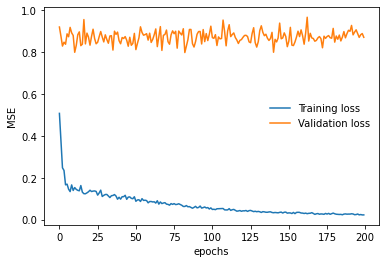

In [49]:
plt.plot(
    np.array(train_losses).reshape((n_epochs, -1)).mean(axis=1),
    label='Training loss'
)
plt.plot(
    np.array(test_losses).reshape((n_epochs, -1)).mean(axis=1),
    label='Validation loss'
)
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('MSE')